### Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras-tuner==1.0.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 5.1 MB/s 
     |████████████████████████████████| 1.6 MB 55.2 MB/s 


In [ ]:
!pip install keras-self-attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18912 sha256=b7eafdbb559252dec4c745f63d00db4df361c61d49acea55ce7849798e8ef6d7
  Stored in directory: /root/.cache/pip/wheels/95/b1/a8/5ee00cc137940b2f6fa198212e8f45d813d0e0d9c3a04035a3
Successfully built keras-self-attention


In [ ]:
import keras_tuner as kt 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import itertools
import operator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from pathlib import Path
from sklearn.model_selection import KFold
from sklearn.utils import resample
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns
from keras.layers import Layer
from keras_self_attention import SeqSelfAttention
import keras.backend as K
from collections import Counter
import itertools
import operator

### Init Parameters

In [ ]:
maxlength = 20 # Maximum length of each sequence
crossvalidation = KFold(5) # k-fold cross-validation
epochs = 500 # Number of epochs
batch_size = 32 # Batch size
imbalanced = False # Turn off if dataset is not unbalanced
MIC_cutoff = 40

In [ ]:
# Transforming csv file into pandas dataframe, then transferring sequences and MICs to separate lists
classification_sequences = pd.read_csv('/datasets/ecoli/activity_ecoli_strains_dataset_v1.csv');
#classification_sequences = classification_sequences.loc[(classification_sequences.e_coli > 0)]
amps_sequences = classification_sequences['sequence'].to_list()
print('Number of sequences:', len(amps_sequences)) # Displays the number of total sequences

Number of sequences: 4821


In [ ]:
classification_sequences['seqLength'] = classification_sequences['sequence'].map(lambda x: len(str(x)))

In [ ]:
classification_sequences["seqLength"].describe()

count    4821.000000
mean       19.627878
std        11.364924
min         1.000000
25%        13.000000
50%        17.000000
75%        24.000000
max       140.000000
Name: seqLength, dtype: float64

Text(0.5, 0.98, 'Sequance Lenght distribution')

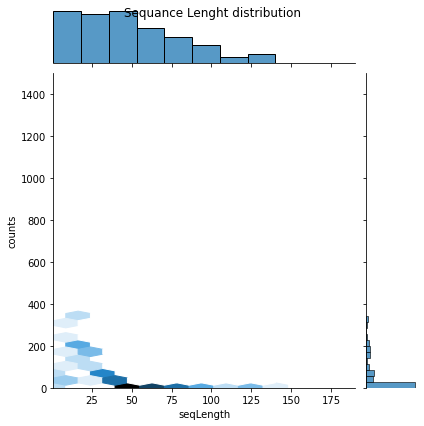

In [ ]:
# statistics about gram- group and activity profile
seqlenghtStatistic = classification_sequences.groupby(['seqLength']).size().reset_index(name='counts')
seqlenghtStatistic
x_len = seqlenghtStatistic['seqLength']
y_count = seqlenghtStatistic['counts']

sns.jointplot(x=x_len, y=y_count,
              kind='hex', xlim=(1,190), ylim=(0,1500))
plt.suptitle("Sequance Lenght distribution")

In [ ]:
df = classification_sequences.drop(classification_sequences[classification_sequences['sequence'].str.len() > maxlength].index)
df

,Unnamed: 0,sequence,nTerminus,cTerminus,e_coli,e_coli_atcc,seqLength
4,6,KAaaKWAaKaAK,C16,AMD,NaN,6.25,12
5,7,KLlK,C16,AMD,NaN,100.00,4
7,10,kGGGkWGGkGGk,C16,AMD,NaN,25.00,12
8,13,KLllKWLlKlLK,NaN,AMD,NaN,15.00,12
10,16,KLALKLALKAWKAALKLA,NaN,AMD,3.9,NaN,18
...,...,...,...,...,...,...,...
4717,54,KWKLFKKILLKFLHLAKLF,-,-,12.0,NaN,19
4718,55,KYYSRVRGGRSAVLSSLDK,-,-,4.0,NaN,19
4719,56,SSGWVCTLTIECGTVICAC,-,-,200.0,NaN,19
4720,57,VDKGSYLPRPTSHPRPIRV,-,-,3.0,NaN,19


In [ ]:
no_df = df.loc[df['e_coli'].isnull()]
no_df

,Unnamed: 0,sequence,nTerminus,cTerminus,e_coli,e_coli_atcc,seqLength
4,6,KAaaKWAaKaAK,C16,AMD,NaN,6.25,12
5,7,KLlK,C16,AMD,NaN,100.00,4
7,10,kGGGkWGGkGGk,C16,AMD,NaN,25.00,12
8,13,KLllKWLlKlLK,NaN,AMD,NaN,15.00,12
11,17,GLRKRLRKFRNKIKEKLKKI,NaN,NaN,NaN,4.00,20
...,...,...,...,...,...,...,...
4507,265,DLRDSWKVIGSDKK,Free,Free,NaN,45.54,14
4608,24,FFLSRIFGK,-,-,NaN,25.00,9
4614,79,TWLKKRRWKKAK,-,-,NaN,64.00,12
4624,265,IAKVALKAL,-,-,NaN,23.60,9


In [ ]:
df.dropna(subset=['e_coli'], inplace= True)
df

,Unnamed: 0,sequence,nTerminus,cTerminus,e_coli,e_coli_atcc,seqLength
10,16,KLALKLALKAWKAALKLA,NaN,AMD,3.900000,NaN,18
12,18,ALWKTLLKKVLKAAAK,NaN,AMD,2.526436,NaN,16
13,19,ALWKTLLKKVLKA,NaN,AMD,5.956335,NaN,13
14,20,KLALKAALKAWKAAAKLA,NaN,AMD,8.250000,NaN,18
15,21,KLALKAAAKAWKAAAKAA,NaN,AMD,91.000000,NaN,18
...,...,...,...,...,...,...,...
4717,54,KWKLFKKILLKFLHLAKLF,-,-,12.000000,NaN,19
4718,55,KYYSRVRGGRSAVLSSLDK,-,-,4.000000,NaN,19
4719,56,SSGWVCTLTIECGTVICAC,-,-,200.000000,NaN,19
4720,57,VDKGSYLPRPTSHPRPIRV,-,-,3.000000,NaN,19


In [ ]:
df["e_coli"].describe()

count     853.000000
mean       69.955223
std       367.123812
min         0.052906
25%         3.750000
50%        10.666484
75%        47.000000
max      7572.133113
Name: e_coli, dtype: float64

In [ ]:
df = df.loc[((df.e_coli > 0) & (df.e_coli < MIC_cutoff) )]
df

,Unnamed: 0,sequence,nTerminus,cTerminus,e_coli,e_coli_atcc,seqLength
10,16,KLALKLALKAWKAALKLA,NaN,AMD,3.900000,NaN,18
12,18,ALWKTLLKKVLKAAAK,NaN,AMD,2.526436,NaN,16
13,19,ALWKTLLKKVLKA,NaN,AMD,5.956335,NaN,13
14,20,KLALKAALKAWKAAAKLA,NaN,AMD,8.250000,NaN,18
16,22,KAIAKSILKWIKSIAKAI,NaN,AMD,5.600000,NaN,18
...,...,...,...,...,...,...,...
4716,53,GWMSKIASGIGTFLSGIQQ,-,-,10.000000,NaN,19
4717,54,KWKLFKKILLKFLHLAKLF,-,-,12.000000,NaN,19
4718,55,KYYSRVRGGRSAVLSSLDK,-,-,4.000000,NaN,19
4720,57,VDKGSYLPRPTSHPRPIRV,-,-,3.000000,NaN,19


In [ ]:
# add non-amp sequnces to dataset to increse the number of negative samples
nonAMP = pd.read_csv('/datasets/non_amp_dataset_and_not_active.csv');
nonAMP['e_coli'] = nonAMP['e_coli'].astype(float)
nonAMP = nonAMP.loc[(nonAMP.e_coli <1001)]
nonAMP

,Unnamed: 0,sequence,nTerminus,cTerminus,e_coli,pseudomonas
0,900001,GEP,NaN,NaN,1000.0,1000
1,900002,MGHP,NaN,NaN,1000.0,1000
2,900003,GTGG,NaN,NaN,1000.0,1000
3,900004,SVTP,NaN,NaN,1000.0,1000
4,900005,MFSPQ,NaN,NaN,1000.0,1000
...,...,...,...,...,...,...
1114,901115,EKFKRSDKSTIKKRYMHLTE,NaN,NaN,1000.0,1000
1115,901116,ERNAHNFPLDLASIEAPTNG,NaN,NaN,1000.0,1000
1116,901117,VAVFSSWARQVLETQKEPDD,NaN,NaN,1000.0,1000
1117,901118,MKRILLLISFLFAPIFAGPA,NaN,NaN,1000.0,1000


In [ ]:
nonAMP = nonAMP.sample(frac=0.51)
nonAMP

,Unnamed: 0,sequence,nTerminus,cTerminus,e_coli,pseudomonas
698,900699,ISGMEQTSFLFQQASK,NaN,NaN,1000.0,1000
201,900202,MLRLNLGLGPAG,NaN,NaN,1000.0,1000
85,900086,AITHSHAEY,NaN,NaN,1000.0,1000
426,900427,QETEEQMELADKA,NaN,NaN,1000.0,1000
731,900732,MEEEQELKTSVKQQDQ,NaN,NaN,1000.0,1000
...,...,...,...,...,...,...
565,900566,DQLFTDEIEELNRK,NaN,NaN,1000.0,1000
581,900582,MELIYKILFTILIR,NaN,NaN,1000.0,1000
740,900741,MNEHVEMLEQQQEVEA,NaN,NaN,1000.0,1000
1083,901084,MNMYIAEPGIYRASNLNLSP,NaN,NaN,1000.0,1000


In [ ]:
frames = [df, nonAMP]
df = pd.concat(frames)
df

,Unnamed: 0,sequence,nTerminus,cTerminus,e_coli,e_coli_atcc,seqLength,pseudomonas
10,16,KLALKLALKAWKAALKLA,NaN,AMD,3.900000,NaN,18.0,NaN
12,18,ALWKTLLKKVLKAAAK,NaN,AMD,2.526436,NaN,16.0,NaN
13,19,ALWKTLLKKVLKA,NaN,AMD,5.956335,NaN,13.0,NaN
14,20,KLALKAALKAWKAAAKLA,NaN,AMD,8.250000,NaN,18.0,NaN
16,22,KAIAKSILKWIKSIAKAI,NaN,AMD,5.600000,NaN,18.0,NaN
...,...,...,...,...,...,...,...,...
565,900566,DQLFTDEIEELNRK,NaN,NaN,1000.000000,NaN,NaN,1000.0
581,900582,MELIYKILFTILIR,NaN,NaN,1000.000000,NaN,NaN,1000.0
740,900741,MNEHVEMLEQQQEVEA,NaN,NaN,1000.000000,NaN,NaN,1000.0
1083,901084,MNMYIAEPGIYRASNLNLSP,NaN,NaN,1000.000000,NaN,NaN,1000.0


In [ ]:
df['e_coli'].fillna(2000.0, inplace=True)

In [ ]:
df['e_isActive'] =  np.where(df['e_coli'] <= MIC_cutoff , True, False)

In [ ]:
df

,Unnamed: 0,sequence,nTerminus,cTerminus,e_coli,e_coli_atcc,seqLength,pseudomonas,e_isActive
10,16,KLALKLALKAWKAALKLA,NaN,AMD,3.900000,NaN,18.0,NaN,True
12,18,ALWKTLLKKVLKAAAK,NaN,AMD,2.526436,NaN,16.0,NaN,True
13,19,ALWKTLLKKVLKA,NaN,AMD,5.956335,NaN,13.0,NaN,True
14,20,KLALKAALKAWKAAAKLA,NaN,AMD,8.250000,NaN,18.0,NaN,True
16,22,KAIAKSILKWIKSIAKAI,NaN,AMD,5.600000,NaN,18.0,NaN,True
...,...,...,...,...,...,...,...,...,...
565,900566,DQLFTDEIEELNRK,NaN,NaN,1000.000000,NaN,NaN,1000.0,False
581,900582,MELIYKILFTILIR,NaN,NaN,1000.000000,NaN,NaN,1000.0,False
740,900741,MNEHVEMLEQQQEVEA,NaN,NaN,1000.000000,NaN,NaN,1000.0,False
1083,901084,MNMYIAEPGIYRASNLNLSP,NaN,NaN,1000.000000,NaN,NaN,1000.0,False


In [ ]:
df = df.sort_values(by=['e_coli'], ascending=[True])

In [ ]:
df = df.drop_duplicates(subset='sequence', keep="first")

In [ ]:
df = df[['sequence', 'e_isActive']]
df.head()

,sequence,e_isActive
515,RRWCFRVCYRGFCYRKCR,True
290,GNNRPVYIPQPRPPHPRL,True
3004,GNNKPVYKPQPRPPHPRL,True
3005,GNNKPVYRPQPRPPHPRL,True
4680,ERSAAKSAARSLARR,True


In [ ]:
df.sequence.map(lambda x: len(x)).max()

20

In [ ]:
# statistics about positive and negative samples
groupActivityStatistic = df.groupby(['e_isActive']).size().reset_index(name='counts')
groupActivityStatistic

,e_isActive,counts
0,False,571
1,True,572


In [ ]:
# Split dataset into training (4/5) and test (1/5) sets; out of every 5 sequences, grab the 3rd for the test set
# Dataset will already be sorted by MIC primarily (meaning negative controls are at the bottom) and sequence length secondarily in Excel
included_sequences = df['sequence'].to_list()
included_MICs = df['e_isActive'].to_list()

training_sequences = df['sequence'].to_list()
del training_sequences[2::5]
test_sequences = included_sequences[2::5] # Grabs the 3rd sequence every 5 steps
training_MICs = df['e_isActive'].to_list()
del training_MICs[2::5]
test_MICs = included_MICs[2::5]

In [ ]:
# Zip corresponding sequences and labels together
training_set = list(zip(training_sequences, training_MICs))
test_set = list(zip(test_sequences, test_MICs))

In [ ]:
len(training_set)

914

In [ ]:
from collections import Counter
Counter(elem[1] for elem in training_set)

Counter({True: 458, False: 456})

In [ ]:
len(test_set)

229

In [ ]:
Counter(elem[1] for elem in test_set)

Counter({True: 114, False: 115})

In [ ]:
# Shuffle sequences and labels, with corresponding sequences and labels kept together
# Split the sequences and labels in training_set and test_set into separate lists again
random.seed(16)
random.shuffle(training_set)
training_sequences, training_MICs = zip(*training_set)
random.shuffle(test_set)
test_sequences, test_MICs = zip(*test_set)

In [ ]:
# Function for zero-padding the sequences
def padding(sequences):
    padded_sequences = []
    for i in range(0, len(sequences)):
        if len(sequences[i]) == maxlength:
            padded_sequences.append(sequences[i])
        else:
            padded_sequences.append(sequences[i] + "0" * (maxlength - len(sequences[i])))
    return padded_sequences

In [ ]:
# Pad the training sequences and test sequences
padded_training_sequences = padding(training_sequences)
padded_test_sequences = padding(test_sequences)

In [ ]:
# Mapping of unique characters to integers
chars = ['A', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '0']
token_index = dict(zip(chars, range(0, 20)))

In [ ]:
# Function for one-hot encoding sequences into binary arrays
def one_hot_encode(sequences):
    x = np.zeros((len(sequences), maxlength, len(chars))) 
    for i, sequence in enumerate(sequences): 
        for j, char in enumerate(sequence[0 : 20]): 
            index = token_index.get(char) 
            x[i, j, index] = 1 
    return x

In [ ]:
# One-hot encode training and test sequences
print('One-hot encoding the sequences...')
# x_train list contains one-hot encoded versions of the 20 residues of each training sequence
x_train = one_hot_encode(padded_training_sequences) 
# x_test list contains one-hot encoded versions of the 20 residues of each test sequence
x_test = one_hot_encode(padded_test_sequences) 

One-hot encoding the sequences...


In [ ]:
len(x_train)

914

In [ ]:
# Vectorize labels
y_train = np.asarray(training_MICs).astype('float64')
y_test = np.asarray(test_MICs).astype('float64')

In [ ]:
len(y_train)

914

In [ ]:
len(x_test)

229

### Preparing The Model

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# Callbacks (checkpoints to save model weights each time it improves, stops training when there is no improvement)
callbacks = [keras.callbacks.EarlyStopping(monitor = 'acc', patience = 5, mode = 'max'), 
             keras.callbacks.ModelCheckpoint(filepath = '/content/sample_data/cnn_lstm_att_ecoli_main_classification_model_v1.h5', monitor = 'acc', 
                                             verbose = 0, save_best_only = True, mode = 'max')]

In [ ]:

# Function that builds model
def build_model(hp):
    model = tf.keras.models.Sequential() # Sequential model
    # Tune the number of units in the LSTM layer; picks an optimal value between 32-512
    hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
    # Add CNN layer
    model.add(layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu',input_shape=(maxlength, len(chars))))
    model.add(layers.MaxPooling1D(pool_size=2))
    # Add a bidirectional LSTM layer
    model.add(layers.Bidirectional(layers.LSTM(hp_units, return_sequences = True), input_shape = (maxlength, len(chars))))
    model.add(layers.Bidirectional(layers.LSTM(hp_units, return_sequences = True), input_shape = (maxlength, len(chars))))
    model.add(SeqSelfAttention(attention_activation='softmax'))
    #model.add(layers.Attention())
   # model.add(BahdanauAttention(hp_units))
    # Picks an optimal value of dropout between
    hp_dropout = hp.Float('dropout', min_value = 0.3, max_value = 0.7, step = 0.1)
    model.add(layers.Dropout(hp_dropout)) # Adds a Dropout layer
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation = 'sigmoid')) # Sigmoid last-layer activation
    # Tune the learning rate; picks an optimal value from the different learning rates  [1e-1, 1e-2, 2e-2, 3e-2, 1e-3, 1e-4]
    hp_learning_rate = hp.Choice('learning_rate', values = [3e-3])
    model.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.RMSprop(hp_learning_rate), metrics = ['acc'])
    # Saving the weights of the model before training start, so we can reset the weights if needed
    model.save_weights('/content/sample_data/initial_cnn_lstm_att_ecoli_main_classification_model_v1.h5') 
    return model

In [ ]:
# Subclassing keras tuner to support cross-validation
class tuner_crossvalidation(kt.engine.tuner.Tuner):
    def run_trial(self, trial, x_train, y_train, batch_size = batch_size, epochs = epochs, callbacks = callbacks):
        val_accuracies = []
        for train_indices, test_indices in crossvalidation.split(x_train):
            x_cvtrain, x_cvtest = x_train[train_indices], x_train[test_indices]
            y_cvtrain, y_cvtest = y_train[train_indices], y_train[test_indices]
            model = self.hypermodel.build(trial.hyperparameters)
            model.fit(x_cvtrain, y_cvtrain, batch_size = batch_size, epochs = epochs, callbacks = callbacks)
            val_accuracies.append(model.evaluate(x_cvtest, y_cvtest))
        self.oracle.update_trial(trial.trial_id, {'val_acc': np.mean(val_accuracies)})
        self.save_model(trial.trial_id, model)

In [ ]:
tuner = tuner_crossvalidation(hypermodel = build_model, 
                              oracle = kt.oracles.BayesianOptimization(objective = 'val_acc', max_trials = 11))

In [ ]:
# Show search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.3, 'max_value': 0.7, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.003, 'conditions': [], 'values': [0.003], 'ordered': True}


### Find Best Tuning Params

In [ ]:
# Run the hyperparameter search
tuner.search(x_train, y_train, batch_size = batch_size, epochs = epochs, callbacks = callbacks)
best_model = tuner.get_best_models()[0]

Trial 11 Complete [00h 01m 17s]
val_acc: 0.6970419988036156

Best val_acc So Far: 0.8881943643093109
Total elapsed time: 00h 16m 25s


In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
Completed hyperparameter search. The optimal number of units in the LSTM
layer is {best_hps.get('units')}. The optimal dropout for the dropout layer is {best_hps.get('dropout')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}. 
""")


Completed hyperparameter search. The optimal number of units in the LSTM
layer is 192. The optimal dropout for the dropout layer is 0.5.
The optimal learning rate for the optimizer is 0.003. 



### Training The Model

In [ ]:
# Function for plotting the accuracy
def plot_acc():
    acc = history.history['acc']
    epochs = range(1, len(acc) + 1)
    plt.figure(1)
    plt.plot(epochs, acc, 'b-', label = 'Training accuracy')
    plt.title('Training accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()  

In [ ]:
# Build and train the model with most optimal hyperparameters on all training sequences; plotting the loss and accuracy
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, callbacks = callbacks)

Epoch 1/500
29/29 [==============================] - 6s 15ms/step - loss: 0.6669 - acc: 0.6346
Epoch 2/500
29/29 [==============================] - 0s 13ms/step - loss: 0.2771 - acc: 0.8917
Epoch 3/500
29/29 [==============================] - 0s 12ms/step - loss: 0.2118 - acc: 0.9234
Epoch 4/500
29/29 [==============================] - 0s 13ms/step - loss: 0.1707 - acc: 0.9420
Epoch 5/500
29/29 [==============================] - 0s 13ms/step - loss: 0.1457 - acc: 0.9420
Epoch 6/500
29/29 [==============================] - 0s 12ms/step - loss: 0.1427 - acc: 0.9464
Epoch 7/500
29/29 [==============================] - 0s 13ms/step - loss: 0.1230 - acc: 0.9562
Epoch 8/500
29/29 [==============================] - 0s 13ms/step - loss: 0.1032 - acc: 0.9694
Epoch 9/500
29/29 [==============================] - 0s 13ms/step - loss: 0.1400 - acc: 0.9464
Epoch 10/500
29/29 [==============================] - 0s 13ms/step - loss: 0.0516 - acc: 0.9858
Epoch 11/500
29/29 [=============================

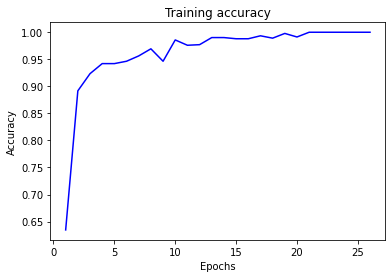

In [ ]:
# Plots figure of accuracy
plot = plot_acc()

### Evaluatation

In [ ]:
# Evaluate optimised model on a never-seen before test set
test_score = model.evaluate(x_test, y_test)
print('Test score (loss value, validation accuracy): ', test_score)

8/8 [==============================] - 2s 9ms/step - loss: 0.5667 - acc: 0.9651
Test score (loss value, validation accuracy):  [0.5667336583137512, 0.9650654792785645]


In [ ]:
# Load our best model
model = load_model('/content/sample_data/cnn_lstm_att_ecoli_main_classification_model_v1.h5', custom_objects={"SeqSelfAttention": SeqSelfAttention})

In [ ]:
# Function for plotting the ROC and AUC
def plot_roc_auc():
    plt.figure(2)  
    plt.plot([0, 1], [0, 1], 'g--') # plots the diagonal line where fpr = tpr
    plt.plot(fpr, tpr, label = 'AUC = {:.3f}'.format(roc_auc))
    plt.scatter(fpr[max_value], tpr[max_value], marker = 'o', color = 'red', label = 'Best decision boundary = {:.5f}'.format(best_threshold))
    plt.title('ROC curve')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend(loc = 'best')
    plt.show

In [ ]:
# Function for plotting the confusion matrix
def plot_conf_matrix():
    plt.figure(3)
    plt.imshow(conf_matrix, cmap = plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.xlabel('Predicted label', fontweight = 'bold')
    plt.ylabel('True label', fontweight = 'bold')
    labels = ['Non-antimicrobial', 'Antimicrobial']
    plt.xticks([0, 1], labels)
    plt.yticks([0, 1], labels, rotation = 90, va = 'center')
    thresh = conf_matrix.max()/2
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
         plt.text(j, i, conf_matrix[i, j], ha = 'center', color = 'white' if conf_matrix[i, j] > thresh else "black")
    plt.colorbar()
    plt.show()

Best threshold = 0.673793


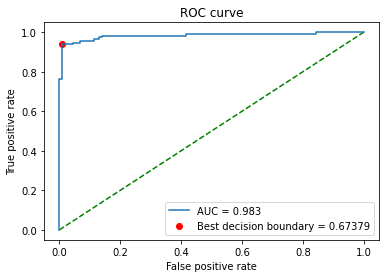

In [ ]:
# Plot the ROC curve and AUC; determine decision boundary   
y_pred = model.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
J = tpr - fpr # Using Youden's J statistic for calculation of best threshold
max_value = np.argmax(J)
best_threshold = thresholds[max_value]
print('Best threshold = %f' % (best_threshold))
plot2 = plot_roc_auc()

[[114   1]
 [  7 107]]


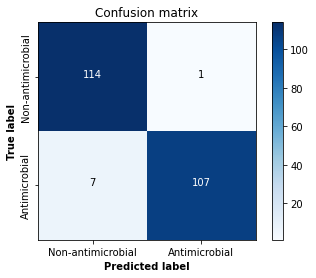

In [ ]:
# Plot the confusion matrix
for i in range(len(y_pred)):
    if y_pred[i] >= best_threshold:
        y_pred[i] = 1
    else: y_pred[i] = 0
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
plot3 = plot_conf_matrix()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97       115
         1.0       0.99      0.94      0.96       114

    accuracy                           0.97       229
   macro avg       0.97      0.96      0.97       229
weighted avg       0.97      0.97      0.97       229



In [ ]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, y_pred)

0.9313939713091521